# Generating OBC and IC for CCS1 from global MOM6 model output

In [1]:
import xarray as xr
import xesmf
# GFDL_xr is only a wrapper to xarray open functions with embedded dmget
# can be replaced by xr if not GFDL
import GFDL_xr
# gridfill is triggering eager computation, needs replacement
#import gridfill

## 1. Loading MOM6 model output from the global model

In [2]:
dirdata = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'

In [3]:
dsgrid = GFDL_xr.open_dataset(dirdata + 'ocean_monthly_z/ocean_monthly_z.static.nc', decode_times=False)

In [4]:
ds = GFDL_xr.open_mfdataset(dirdata + 'ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.*.thetao.nc',
                            decode_times=False, combine='by_coords')

In [5]:
ds = xr.merge([ds, dsgrid])

In [6]:
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 720, xh: 1440, xq: 1440, yh: 1080, yq: 1080, z_i: 36, z_l: 35)
Coordinates:
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * nv            (nv) float64 1.0 2.0
  * z_l           (z_l) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * z_i           (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * time          (time) float64 15.5 45.0 74.5 ... 2.184e+04 2.187e+04 2.19e+04
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    average_DT    (time) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1    (time) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2    (time) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    thetao        (time, z_l, yh, xh) float32 dask.array<chunksize=(60, 35, 1080, 1440), meta=np.ndarray>
    time_bnds     (time, nv) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (yh, xh) float32 ...
    dxCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dxt           (yh, xh) float32 ...
    dyCu          (yh, xq) float32 ...
    dyCv          (yq, xh) float32 ...
    dyt           (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolat_u      (yh, xq) float32 ...
    geolat_v      (yq, xh) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    geolon_u      (yh, xq) float32 ...
    geolon_v      (yq, xh) float32 ...
    hfgeou        (yh, xh) float32 ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...

## 2. Loading the regional grid

In [7]:
ds_ccs = xr.open_dataset('ocean_hgrid_ccs1.nc')

In [8]:
ds_ccs

<xarray.Dataset>
Dimensions:   (nx: 360, nxp: 361, ny: 960, nyp: 961)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    angle_dx  (nyp, nxp) float32 ...
    y         (nyp, nxp) float32 ...
    x         (nyp, nxp) float32 ...
    dx        (nyp, nx) float32 ...
    dy        (ny, nxp) float32 ...
    area      (ny, nx) float32 ...
    tile      |S5 ...
Attributes:
    history:  Mon Jul 11 14:52:29 2016: ncatted -a units,y,m,c,degree_north o...
    NCO:      "4.5.5"

## 3. Regridding to Open Boundaries

In [9]:
# northern boundary
north = xr.Dataset()
north['lon'] = ds_ccs['x'].isel(nyp=-1)
north['lat'] = ds_ccs['y'].isel(nyp=-1)

# southern boundary
south = xr.Dataset()
south['lon'] = ds_ccs['x'].isel(nyp=0)
south['lat'] = ds_ccs['y'].isel(nyp=0)

# western boundary
west = xr.Dataset()
west['lon'] = ds_ccs['x'].isel(nxp=0)
west['lat'] = ds_ccs['y'].isel(nxp=0)


For computational efficiency, we are going to take a subset of the global grid so we reduce the size of the remapping matrix:

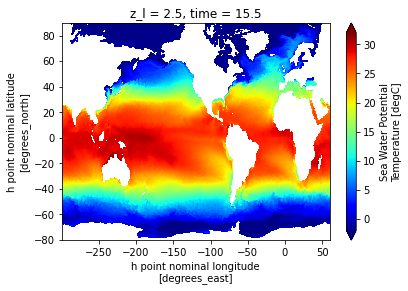

In [10]:
ds['thetao'].isel(time=0, z_l=0).plot(vmin=-2, vmax=32, cmap='jet')

In [11]:
ds_cut = ds.sel(xh=slice(-150, -100), yh=slice(15,55),
                xq=slice(-150, -100), yq=slice(15,55))

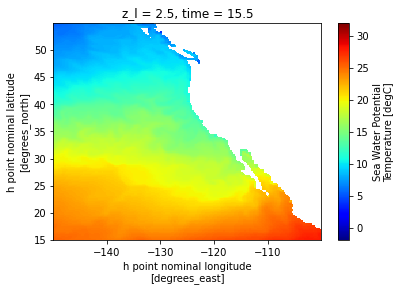

In [12]:
ds_cut['thetao'].isel(time=0, z_l=0).plot(vmin=-2, vmax=32, cmap='jet')

In [13]:
#test,_ = xr.apply_ufunc(gridfill.fill, ds_cut['thetao'].isel(time=0).to_masked_array(), 2, 1, 1e-3, kwargs={'initzonal': True},
#                                         dask='parallelized', output_dtypes=ds_cut.thetao.dtype)

In [15]:
#plt.pcolormesh(test[0,:,:], vmin=-2, vmax=32, cmap='jet')

In [16]:
# EAGER!

#def myfill(*args, **kwargs):
#    out, _ = gridfill.fill(*args, **kwargs)
#    return out
    
#test = xr.apply_ufunc(myfill, ds_cut['thetao'].to_masked_array(), 2, 1, 1e-3, kwargs={'initzonal': True},
#                      dask='parallelized', output_dtypes=[ds_cut.thetao.dtype])

In [17]:
#test.isel(time=10, z_l=10).plot()

In [18]:
regrid_north = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), north, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_north.nc')

Overwrite existing file: regrid_north.nc 
 You can set reuse_weights=True to save computing time.


In [19]:
regrid_south = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), south, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_south.nc')

Overwrite existing file: regrid_south.nc 
 You can set reuse_weights=True to save computing time.


In [20]:
regrid_west = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), west, 'bilinear', 
                              locstream_out=True, periodic=False, filename='regrid_west.nc')

Overwrite existing file: regrid_west.nc 
 You can set reuse_weights=True to save computing time.


In [21]:
temp_north = regrid_north(ds_cut['thetao'])

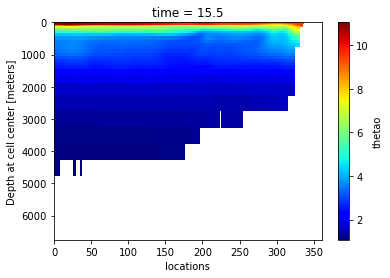

In [22]:
temp_north.isel(time=0).plot(yincrease=False, cmap='jet')

In [23]:
temp_south = regrid_south(ds_cut['thetao'])

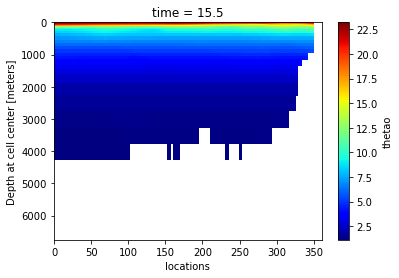

In [24]:
temp_south.isel(time=0).plot(yincrease=False, cmap='jet')

In [25]:
temp_west = regrid_west(ds_cut['thetao'])

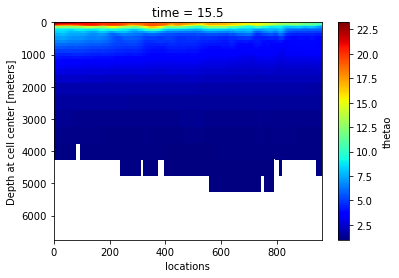

In [26]:
temp_west.isel(time=0).plot(yincrease=False, cmap='jet')

## 4. Initial conditions

In [27]:
regrid_domain = xesmf.Regridder(ds_cut.rename({'geolon': 'lon', 'geolat': 'lat'}), ds_ccs.rename({'x': 'lon', 'y': 'lat'}), 'bilinear', 
                                periodic=False, filename='regrid_domain.nc')

Overwrite existing file: regrid_domain.nc 
 You can set reuse_weights=True to save computing time.


In [28]:
temp_ic_ccs = regrid_domain(ds_cut['thetao'])

In [29]:
temp_ic_ccs

<xarray.DataArray 'thetao' (time: 720, z_l: 35, nyp: 961, nxp: 361)>
dask.array<regrid_numpy, shape=(720, 35, 961, 361), dtype=float64, chunksize=(60, 35, 961, 361), chunktype=numpy.ndarray>
Coordinates:
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * time     (time) float64 15.5 45.0 74.5 ... 2.184e+04 2.187e+04 2.19e+04
    lon      (nyp, nxp) float32 239.18677 239.21523 ... 233.27739 233.31824
    lat      (nyp, nxp) float32 18.657413 18.671423 ... 50.278313 50.2939
Dimensions without coordinates: nyp, nxp
Attributes:
    regrid_method:  bilinear

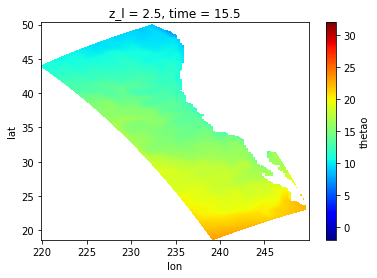

In [30]:
temp_ic_ccs.isel(time=0, z_l=0).plot(x='lon', y='lat', vmin=-2, vmax=32, cmap='jet')